### Download the dataset and understand the format
In the next cell we download the data from the repo, extact, organize it and we delete the ```thumb.db``` files so it is not read as images with the ```os.listdir``` function

In [146]:
# download data

import tarfile
import sys
import os
from shutil import copyfile
from subprocess import call
from IPython.display import HTML, display


data_zip = 'BSR_bsds500.tgz'
data_dirc = "data"
normalized_train_dirc = os.path.join(data_dirc, 'normalized_train')
if not os.path.isdir(data_dirc):
    print("data file not found.")
    print("checking if zip file exists")
    if not os.path.exists(data_zip):
        print("zip file does not exist.")
        print("downloading data...")
        url = "http://web.archive.org/web/20120508113820if_/http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
        filename = wget.download(url)
        print("download " + filename)
        print("data downloaded")
    else:
        print("Zip file exists")

    print("extracting data")
    tar = tarfile.open(data_zip, "r")
    tar.extractall()
    
    if not os.path.isdir(data_dirc):
        os.makedirs(data_dirc)
    os.popen('cp -r BSR/BSDS500/data/images/* data').read()
    os.popen('cp -r BSR/BSDS500/data/groundTruth data/').read()
    os.remove('data/train/Thumbs.db')
    
    if not os.path.isdir(normalized_train_dirc):
        os.makedirs(normalized_train_dirc)
        lines = open('normalized_train.txt').read().splitlines()
        for image_name in lines:
            copyfile(os.path.join(data_dirc, 'train', image_name), os.path.join(normalized_train_dirc, image_name))

else:
    print("data found")
    
os.system('rm -rf $(find -name "thumb.db")')

def progress_bar(value, max, status=''):
    return HTML(("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
        <label>{status}</label>
        <br />
        <label>{progress_value}%</label>
    """).format(value=value, max=max, status=status, progress_value=(value * 100.0)/max))



data file not found.
checking if zip file exists
Zip file exists
extracting data


### Visualize the image and the ground truth segmentation
The next cell contains a function that reads the .mat file which represent the groundTruth segmentation and plots it

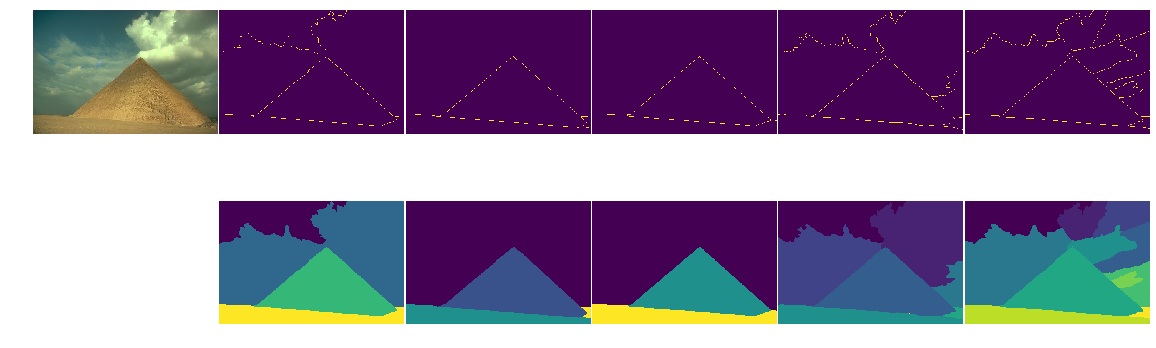

In [147]:
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.image import imread

dirc_truth = os.path.join(data_dirc, 'groundTruth')

def show_image_groundTrue(image_path):
    
    fig = plt.figure(figsize=(20, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.01)
    n = 2
    m = 6
    j = 1
    img = imread(os.path.join(data_dirc, image_path))
    fig.add_subplot(n, m, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img)
    
    image_path = image_path.replace('jpg', 'mat')
    mat = scipy.io.loadmat(os.path.join(dirc_truth, image_path))
    
    for i in range(0, 5):
        x = mat['groundTruth'][0][i][0][0][1]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    j = j + 1
    for i in range(0, 5):
        x = mat['groundTruth'][0][i][0][0][0]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    plt.show()
    
pyramid_image = "299091.jpg"
show_image_groundTrue(os.path.join('train', pyramid_image))


### Segmentation using K-means
The next cell provides a function that takes the image and the number of clusters as parameters to perform the image segmentation using K-means algorithm.

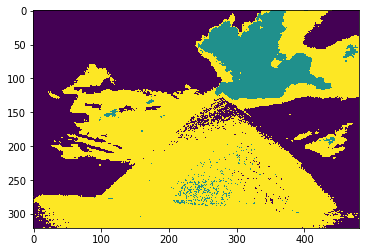

In [148]:
# kmeans
from sklearn.cluster import KMeans

def kmeans_cluster(img, n_clusters):
    
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    
    img = img.reshape(n * m, colors) # n * m rows each with a vector of RGB
    kmeans = KMeans(n_clusters=n_clusters, precompute_distances=True,n_jobs=-1).fit(img)
    
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
#     for i in range(0, n * m):
#         img[i] = centers[labels[i]]
    
    labels = labels.reshape(n, m)
    return labels


dirc_train = os.path.join(data_dirc, "train")
dirc_kmeans = os.path.join(data_dirc, "kmeans")

img = imread(os.path.join(dirc_train, pyramid_image))
img.flags.writeable = True
result = kmeans_cluster(img, 3)
plt.imshow(result)
plt.show()
# print(result)







#### Running  the algorithm for k in {3, 5, 7, 9, 11} :
The following cell introduces a function that performs the segmentation using K-means method on all the dataset and using k = {3, 5, 7, 9, 11}. It depends on ```kmeans_cluster(img, n_clusters):``` to run the K-means. Also the results are saved in the ```kmeans/$(run_number)/$(cluster_number)``` directory.

In [12]:
import numpy as np
import imageio

def kmeans_images(original_path, result_path, segs):
    print("processing images in " + original_path + " writing result to " + result_path +
         " for clusters " + str(segs))
    
    images = os.listdir(original_path)
    n = len(images)
    i = 1
    bar = display(progress_bar(0, n), display_id=True)
    for image in images:
        i = i + 1
        
        img = imread(os.path.join(original_path, image))
        for seg in segs:
            dirc = os.path.join(result_path, str(seg))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
                
            c = np.copy(img)
            result = kmeans_cluster(c, seg)
            np.save(os.path.join(dirc, image), result)
            bar.update(progress_bar(i, n, "Image= {image}, Seg= {seg}".format(image=image,seg=seg)))
        
    print("kmeans done")

n_tirals = 1
for i in range(1, n_tirals + 1):
    print("run number: " + str(i))
    f = "run_" + str(i)
    kmeans_images(dirc_train, os.path.join(dirc_kmeans, f), [3,5,7,9,11])

run number: 1
processing images in data/train writing result to data/kmeans/run_1 for clusters [3, 5, 7, 9, 11]


kmeans done


#### Plot results for different clusters.
The following cell uses the pyramid image as a sample to show the segmentation results for different values of k. We can notice the the more clusters we add the more details we can see in the result.

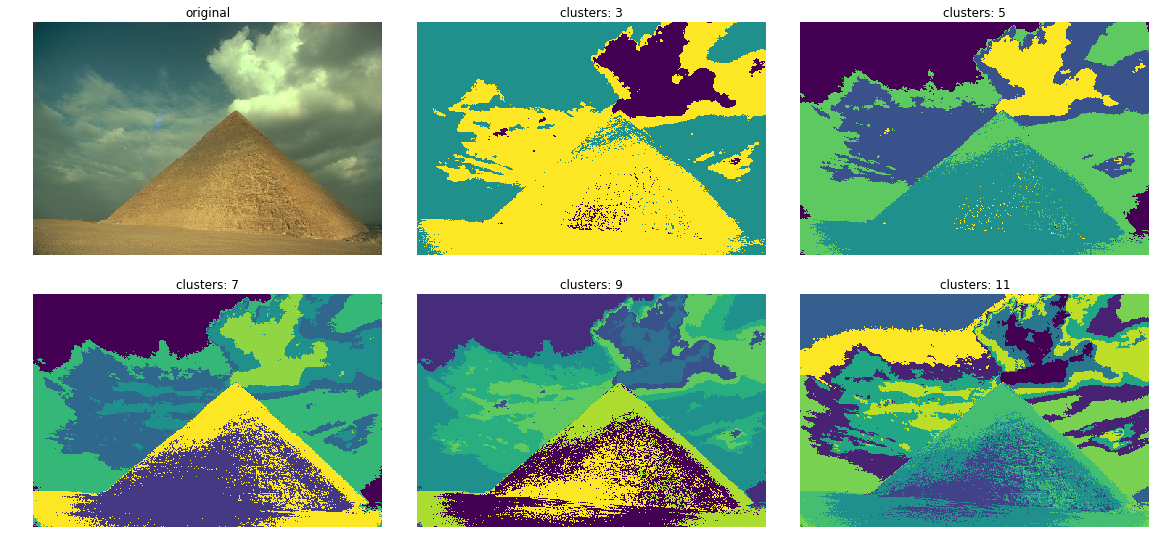

In [149]:
# display image and it's segmentation
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

def visualize(image_name, original_path, segmentation_path, segs):

    img = imread(os.path.join(original_path, image_name))

    
    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    
    l = len(segs) + 1
    n = 2
    m = l // n
    
    fig.add_subplot(n, m, 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img)
    
    i = 2
    for f in segs:
        img = np.load(os.path.join(segmentation_path, f, image_name + ".npy"))
        fig.add_subplot(n, m, i)
        plt.axis('off')
        plt.title('clusters: ' + f)
        plt.imshow(img)
        
        i = i + 1
        
#     plot(img)
    plt.show()

dirc_train = os.path.join(data_dirc, "train")
dirc_kmeans = os.path.join(data_dirc, "kmeans")
pyramid_image = "299091.jpg"
segs = ["3", "5", "7", "9", "11"]
visualize(pyramid_image, dirc_train, os.path.join(dirc_kmeans, "run_1"), ["3", "5", "7", "9", "11"])





#### f_measure and conditional Entropy.
The next two cells provide an implementation for the segmentation results.
* The first cell provides an implementation for the f_measure as shown in the lecture slides.
* The second cell provides an implementation for the conditional entropy as shown in the lecture slides.

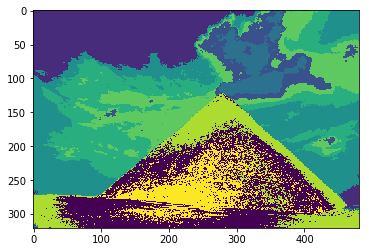

0.44584483107708195


In [71]:
# F-measure
from skimage import img_as_uint
from skimage.filters import sobel
from skimage.transform import resize

def cluster_freq(clusters, truth):
    freq = {}
    g = {}
    for c, t in zip(clusters, truth):
        if not c in freq:
            freq[c] = {}
        
        if not t in freq[c]:
            freq[c][t] = 0
        
        freq[c][t] = freq[c][t] + 1
        
        if not t in g:
            g[t] = 0
        g[t] = g[t] + 1
        
    return (freq, g)


# clusters and truth are two dimention arrays
def f_measure(clusters, truth):
    
    (n, m) = clusters.shape
    (nn, mm) = truth.shape
    clusters = clusters.reshape(n * m)
    truth = resize(truth, (n, m),anti_aliasing=False)
    truth = img_as_uint(truth);
    truth = truth.reshape(n * m)
    # map of cluster id (from clusters) to a map of cluster id (from truth)
    # and it's frequency
    (freq, g) = cluster_freq(clusters, truth)
    
    f_score = 0
    n = 0
    for k, v in freq.items(): # for each cluster
        total = 0
        max_index = -1
        max_count = -1
        
        for a, f in v.items():
            total = total + f
            if(f > max_count):
                max_count = f
                max_index = a
                
        prec = max_count * 1.0 / total
        rec = max_count / g[max_index]
        
        f = 2.0 * (prec * rec) / (prec + rec)
        f_score = f_score + f
        
        n = n + 1
        
    f_score = f_score / n
    return f_score
    
img = np.load(os.path.join(dirc_kmeans, "run_1", "9", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

f = f_measure(img, mat['groundTruth'][0][3][0][0][0])
print(f)





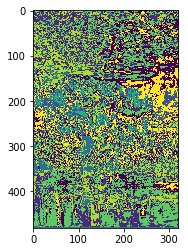

0.6735376365023366


In [110]:
#  Conditional Entropy

# clusters and truth are two dimention arrays
import math
def conditional_entropy(clusters, truth):

    (n, m) = clusters.shape
    size = n * m * 1.0
    truth = resize(truth, (n, m),anti_aliasing=False)
    truth = img_as_uint(truth)
    truth = truth.reshape(n * m)
    clusters = clusters.reshape(n * m)

    
    (freq, g) = cluster_freq(clusters, truth)
    
    ht = 0
    
    for k, v in freq.items():
        t = 0.0 # total elements in cluster
        for a, b in v.items():
            t = t + b
        
        x = 0
        for a, b in v.items():
    
            l = - (b / t) * (math.log(b / t, 10))
            x = x + l
        
        ht += (x * t) / size
    
    return ht


img = np.load(os.path.join(dirc_kmeans, "run_1", "9", "104022.jpg" + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", "104022.mat"))

assert conditional_entropy(img, img) == 0


plt.imshow(img)
plt.show()

f = conditional_entropy(img, mat['groundTruth'][0][3][0][0][0])
print(f)





#### Report results and performance comparisopn
The next 3 cells provide functions that are used to report the run results using f_measure an conditional entropy as performance measure.
* The first cell is creates a map object that will be used to create the report table.
* The second cell creates the report table.
* The third cell shows a comparison between the groundTruth segmentation and the K-means segmenetation

In [122]:
# image metrics

def image_metrics(train_path, result_path, data_type_path='train'):
    
    train_images = os.listdir(train_path)
    ground_truth_dirc = os.path.join(data_dirc, 'groundTruth', data_type_path)
    
    segs = ['3', '5', '7', '9', '11']

    print("calculating performance measures...")
    bar = display(progress_bar(0, len(train_images) * len(segs)), display_id=True)
    
    result = {}
    
    for seg_index in range(0, 5):
        r = {'f_measure' : {'max':0, 'min': 1, 'average':0},
             'entropy':{'max':0, 'min': 1, 'average':0}}
        
        image_number = 0.0
        images_used = 0.0
        skipped_images = []
        for image_name in train_images:
            image_number += 1
            image_code = image_name.replace('.jpg', '')
            kmeans_image = np.load(os.path.join(result_path, segs[seg_index], image_name + ".npy"))
            mat = scipy.io.loadmat(os.path.join(ground_truth_dirc, image_code + ".mat"))
            if (len(mat['groundTruth'][0]) <= seg_index):
                skipped_images.append((segs[seg_index], image_name))
                continue
            g = mat['groundTruth'][0][seg_index][0][0][0]
            
            f1 = f_measure(kmeans_image, g)
            r['f_measure']['max'] = max(r['f_measure']['max'], f1)
            r['f_measure']['min'] = min(r['f_measure']['min'], f1)
            r['f_measure']['average'] = r['f_measure']['average'] + f1
            
            f2 =  conditional_entropy(kmeans_image, g)
            r['entropy']['max'] = max(r['entropy']['max'], f2)
            r['entropy']['min'] = min(r['entropy']['min'], f2)
            r['entropy']['average'] = r['entropy']['average'] + f2
            
            images_used = images_used + 1
            bar.update(progress_bar(seg_index * len(train_images) + image_number, len(train_images) * len(segs), image_name))
        if(len(skipped_images) != 0):
            print(skipped_images)
        r['f_measure']['average'] = r['f_measure']['average'] / images_used
        r['entropy']['average'] = r['entropy']['average'] / images_used
            
        result[seg_index] = r
    print("done calculating performance measures")
    return result
    

metrics = image_metrics(train_path=os.path.join(data_dirc, 'train'),
                        result_path=os.path.join(dirc_kmeans, "run_1"))
print(metrics)
    
    

calculating performance measures...


[('11', '254054.jpg'), ('11', '8143.jpg')]
done calculating performance measures
{0: {'f_measure': {'max': 0.9704372103201107, 'min': 0.2591268260028307, 'average': 0.5459466075624874}, 'entropy': {'max': 1.233509045619947, 'min': 0.011798816132531592, 'average': 0.5057944148681024}}, 1: {'f_measure': {'max': 0.7155263630579228, 'min': 0.20869908564738743, 'average': 0.4490099248059487}, 'entropy': {'max': 1.410995544762771, 'min': 0.011966030395516932, 'average': 0.48436159497534315}}, 2: {'f_measure': {'max': 0.8028237827021341, 'min': 0.19929645808010607, 'average': 0.39214718866642484}, 'entropy': {'max': 1.295899534397945, 'min': 0.010090387705121572, 'average': 0.4607237580735859}}, 3: {'f_measure': {'max': 0.6920601544153396, 'min': 0.17546615866656776, 'average': 0.3516029881349992}, 'entropy': {'max': 1.1706847163490117, 'min': 0.010059315026511015, 'average': 0.4558626950467364}}, 4: {'f_measure': {'max': 0.6259208254828467, 'min': 0.15237673671911123, 'average': 0.3261095898

In [123]:

# from prettytable import PrettyTable
    
# x = PrettyTable()

# x.field_names = ["City name", "Area", "Population", "Annual Rainfall"]

# x.add_row(["Adelaide", 1295, 1158259, 600.5])
# x.add_row(["Brisbane", 5905, 1857594, 1146.4])
# x.add_row(["Darwin", 112, 120900, 1714.7])
# x.add_row(["Hobart", 1357, 205556, 619.5])
# x.add_row(["Sydney", 2058, 4336374, 1214.8])
# x.add_row(["Melbourne", 1566, 3806092, 646.9])
# x.add_row(["Perth", 5386, 1554769, 869.4])

# print(x)
from IPython.display import HTML, display
from tabulate import tabulate

def image_metrics_report(train_path, result_path, data_type_path='train'):

    report = image_metrics(train_path, result_path, data_type_path)
#     print(report)

    rd = 5
    segs =  ['3', '5', '7', '9', '11']
    
    for seg_index in range(5):
        d = report[seg_index]

        table = [["clusters: " + segs[seg_index], "max", "min", "average"],
                 ["f_measure"],
                 ["entropy"]]

        for i in range(1, len(table[0])):
            table[1].append(round(d["f_measure"][table[0][i]], rd))

        for i in range(1, len(table[0])):
            table[2].append(round(d["entropy"][table[0][i]], rd))

        display(HTML(tabulate(table, tablefmt='html')))

    

  
    
image_metrics_report(train_path=os.path.join(data_dirc, 'train'),
                     result_path=os.path.join(dirc_kmeans, "run_1"))




# table = [["Sun",696000,1989100000],
#          ["Earth",6371,5973.6],
#          ["Moon",1737,73.5],
#          ["Mars",3390,641.85]]
# display(HTML(tabulate.tabulate(table, tablefmt='html')))






calculating performance measures...


[('11', '254054.jpg'), ('11', '8143.jpg')]
done calculating performance measures


clusters: 3,max,min,average
f_measure,0.97044,0.25913,0.54595
entropy,1.23351,0.0118,0.50579


clusters: 5,max,min,average
f_measure,0.71553,0.2087,0.44901
entropy,1.411,0.01197,0.48436


clusters: 7,max,min,average
f_measure,0.80282,0.1993,0.39215
entropy,1.2959,0.01009,0.46072


clusters: 9,max,min,average
f_measure,0.69206,0.17547,0.3516
entropy,1.17068,0.01006,0.45586


clusters: 11,max,min,average
f_measure,0.62592,0.15238,0.32611
entropy,1.26241,0.0247,0.48673


As we can see in the results above. As we increase the number of clusters the f_measure and the conditional Entropy decrease.

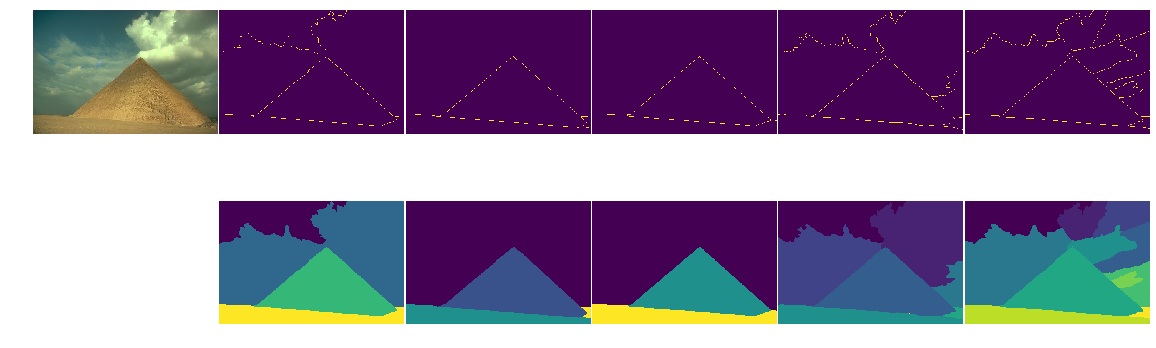

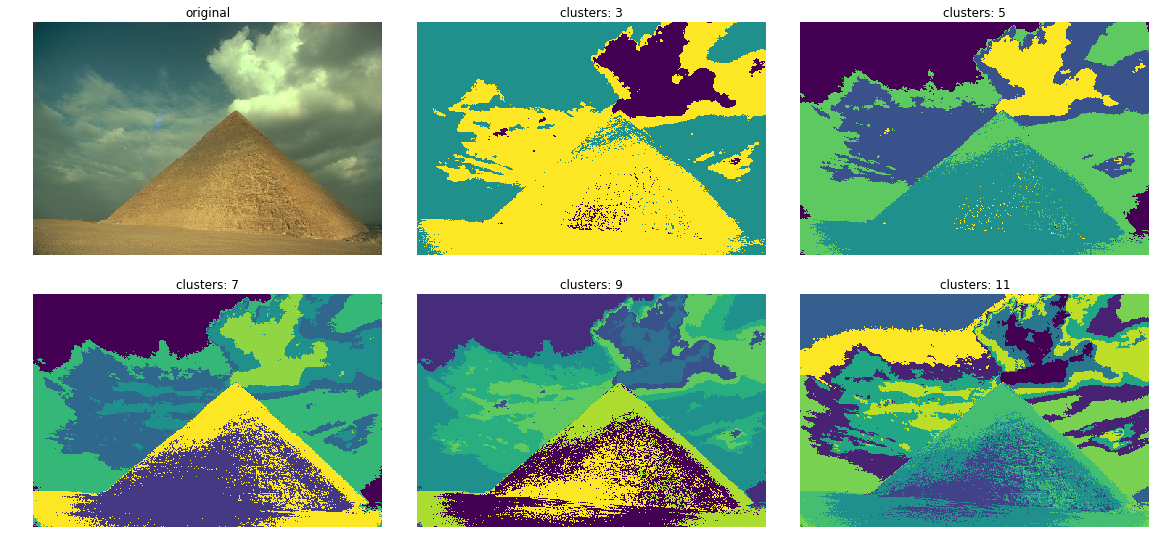

In [125]:


def image_report(original_path, result_path, image_name, segs):
    
    show_image_groundTrue(os.path.join(original_path, image_name))

    visualize(image_name, os.path.join(data_dirc,original_path),
             result_path, segs)   
    
image_report("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)
    

**Normalized Cut** 
- Normalized cut is also known by spectral clustering.
- Here n the spectral_cluster method, it performs the spectral clustering with certain paramaters:
 - n_clusters: the number of clusters.
 - tpe: the type of spectral clustering either rbf or nearest_neighbor
- At the begining the size of the image is changed because it consumes alot of memory space if it is represented in its original size.
- The method SpectralClustering() in sklearn is used in spectral clustering.
- The SpectralClustering() methos accepts only 2d wrapped images images so the image will be reshapped.  

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


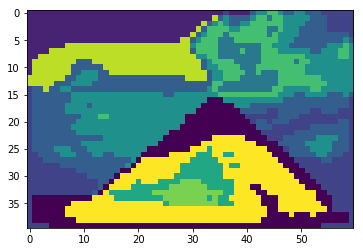

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [2 0 0 ... 0 0 2]
 [2 0 0 ... 0 0 2]
 [2 2 2 ... 2 2 2]]


In [150]:
from sklearn.cluster import SpectralClustering
from skimage.transform import resize

def spectral_cluster(img, n_clusters, tpe, gamma=1):
    img = resize(img, (40, 60), anti_aliasing=True)
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    img = img.reshape(n * m, colors) 
    spectral = SpectralClustering(n_clusters=n_clusters,
                       gamma=gamma, affinity=tpe, 
                       n_neighbors=5,
                       n_jobs=-1).fit(img)    
    labels = spectral.labels_
    labels = labels.reshape(n, m)
    return labels

dirc_normalized_rbf = os.path.join(data_dirc, "normalized_rbf")
dirc_normalized_nn = os.path.join(data_dirc, "normalized_nn") 
img = imread(os.path.join(dirc_train, pyramid_image))
img.flags.writeable = True
result = spectral_cluster(img, 11, 'nearest_neighbors', 1)
# np.save(os.path.join(dirc_normalized_nn, 'run_1', '5_1', pyramid_image), result)
plt.imshow(result)
plt.show()
print(result)

**Two ways for normalized cut**
- The two ways for the normalized cut is:
 - rbf with gamma values [1, 10].
 - Nearest neighbor method.
- Here in this method, all the images in the data set is processed using spectral clustering.
- Here the normalized cut is tested with rbf and nearest neighbor with 3 5 7 9 11 clusters.
- Tt is  tested with two values for gamma 1 and 10.
- The images with gamma = 10 is more sharmer and obvious than gamma = 1.

In [153]:
normalized_train_dirc = os.path.join(data_dirc, 'normalized_train')

def normalized_cut_images(result_path, segs, tpe, gamma):
    print("processing images in " + normalized_train_dirc + " writing result to " + result_path +
         " for clusters " + str(segs))
    images = os.listdir(normalized_train_dirc)
    n = len(images)
    i = 1
    bar = display(progress_bar(0, len(segs) * n), display_id=True)
    for image in images:
        img = imread(os.path.join(normalized_train_dirc, image))
        for seg in segs:
            i = i + 1
            dirc = os.path.join(result_path, str(seg) + "_" + str(gamma))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
            c = np.copy(img)
            bar.update(progress_bar(i, len(segs) * n, "Processing Image= {image}, Seg= {seg}".format(image=image,seg=seg)))
            result = spectral_cluster(c, seg, tpe, gamma)
            np.save(os.path.join(dirc, image), result)
            bar.update(progress_bar(i, len(segs) * n, "Image= {image}, Seg= {seg}".format(image=image,seg=seg)))
    print("normalized_cut_done with " + tpe)

dirc_normalized_rbf = os.path.join(data_dirc, "normalized_rbf")
dirc_normalized_nn = os.path.join(data_dirc, "normalized_nn")
# normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 1)
normalized_cut_images(os.path.join(dirc_normalized_nn, "run_1"), [3,5,7,9,11], 'nearest_neighbors', 1)
normalized_cut_images(os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 10)
normalized_cut_images(os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 1)

processing images in data/normalized_train writing result to data/normalized_nn/run_1 for clusters [3, 5, 7, 9, 11]


/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spec

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully conne

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spec

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spec

/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spec

/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spec

/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be 

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spec

normalized_cut_done with nearest_neighbors
processing images in data/normalized_train writing result to data/normalized_rbf/run_1 for clusters [3, 5, 7, 9, 11]


/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

normalized_cut_done with rbf
processing images in data/normalized_train writing result to data/normalized_rbf/run_1 for clusters [3, 5, 7, 9, 11]


/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mahmoud/anaconda3/envs/default/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

normalized_cut_done with rbf


**Comparison**
- A comparison between the resultant image from rbf with gamma 1 and 10 and nearset neighbor is run.
- The number of clusters used = 11.
- The most sharper and obvious is rbf with gamma = 10
- Then rbf with gamma = 1.
- Then nearest neighbor.

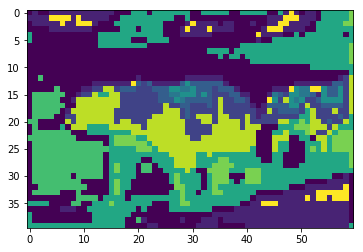

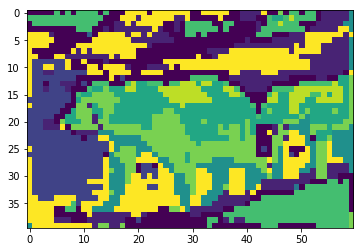

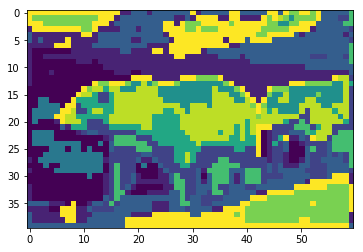

In [154]:
image = '100075.jpg'
img1 = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_10", image + ".npy"))
img2 = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
img3 = np.load(os.path.join(dirc_normalized_nn , "run_1", "11_1", image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

**Measuring the conditional entropy**
- As the conditional entropy decrease, this means that there is a better image.
- The conditional entropy is calculated for rbf 10 and nearest neighbor.
- The conditional entropy is nearly similar between them.

0.4777960461762138


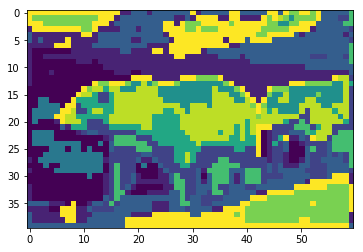

rbf entropy
0.6548744871025652
0.1393672935805539
0.2845790752120405
0.5856063367276685
0.7997324027724777
0.38664202719079843
0.13639220372505803
0.3936435894899617
1.0696835926010309
0.042682194132178546
0.08029912026167145
0.19320298065234576
0.5482448416628808
0.008439580616644867
0.08822996265805702
0.18984358169152632
0.4837667686107114
0.5613236849779892
0.397042076156946
0.6435167965822006
0.35581123643494716
0.46322742839218
0.43941248558586654
0.16824364925365454
0.5582859065154069
0.6111879061131318
0.3553640559825082
0.2070057670499194
0.15848999719647425
0.595675304176001
0.7179840313894504
0.1372630992381497
0.1045132437463849
0.4219512922341018
0.14248600331135533
0.1730834745868907
0.7374661907471265
0.3551215572315538
0.1374363057277645
0.8368674942817429
0.42568403121138326
nn entropy
0.5713426294475233
0.15142200318196633
0.22726438170424643
0.5335700601269081
0.692432063669857
0.36850118945332216
0.12386607404329955
0.23555460294280214
1.001194566709038
0.0537081003

In [158]:
dirc_normalized_nn = os.path.join(data_dirc, "normalized_nn")
dirc_normalized_rbf = os.path.join(data_dirc, "normalized_rbf")
normalized_train_dirc = os.path.join(data_dirc, 'normalized_train')
dirc_truth = os.path.join(data_dirc, 'groundTruth')

img = np.load(os.path.join(dirc_normalized_nn, "run_1", "11_1", '100075.jpg' + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", '100075.jpg'.replace('jpg', 'mat')))
f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
print(f)

plt.imshow(img)
plt.show()

def entropy(path, sub):
    images = os.listdir(normalized_train_dirc)
    for image in images:
        img = np.load(os.path.join(dirc_normalized_rbf, "run_1", sub, image + ".npy"))
        mat = scipy.io.loadmat(os.path.join(dirc_truth, 'train', image.replace('jpg', 'mat')))
        f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
        if(f > 0):
            print(f)
            
print("rbf entropy")
entropy(dirc_normalized_rbf, '11_10')

print("nn entropy")
entropy(dirc_normalized_nn, '11_1')

**Measuring the f-measure**
- As the f-measure increases, this means that there is a better image.
- The f-measure is calculated for rbf 10 and nearest neighbor.
- The f-measure is nearly similar between them.

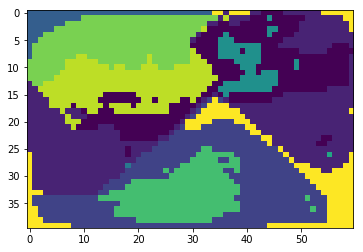

rbf f_measure
0.3116555699716643 65010.jpg
0.33261281646197416 299091.jpg
0.29218799271403956 161062.jpg
0.33312937551205546 35010.jpg
0.5235398239619697 170054.jpg
0.38292945878080004 33066.jpg
0.2897629584605974 35008.jpg
0.27518132396003137 42078.jpg
0.2931188686350698 65019.jpg
0.2766664844630526 67079.jpg
0.26304292375128335 60079.jpg
0.2815136419244038 56028.jpg
0.32417637658674325 100075.jpg
0.15186191336317137 28096.jpg
0.29165755276993793 28075.jpg
0.5057251193024791 46076.jpg
0.22604534834250375 42044.jpg
0.2246180580735753 43083.jpg
0.39103354092303866 68077.jpg
0.3517289792648062 65132.jpg
0.3820528424987896 61060.jpg
0.2718554149507024 35058.jpg
0.435099552572358 55075.jpg
0.2995258908324894 71046.jpg
0.29014446686749495 35091.jpg
0.34259723171100925 108041.jpg
0.39823629708206193 45077.jpg
0.42730680843697183 48055.jpg
0.2345062696775041 26031.jpg
0.2407970122715061 54005.jpg
0.3670069793577026 65074.jpg
0.40856042955979904 55067.jpg
0.33194011259632517 41004.jpg
0.401242

In [162]:
img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

def f(path, sub):
    images = os.listdir(normalized_train_dirc)
    for image in images:
        img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
        mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))
        f = f_measure(img, mat['groundTruth'][0][0][0][0][0])
        if(f > 0):
            print(str(f) + " " + image)
print("rbf f_measure")
f(dirc_normalized_rbf, '11_10')
print("nn f_measure")
f(dirc_normalized_nn, '11_1')


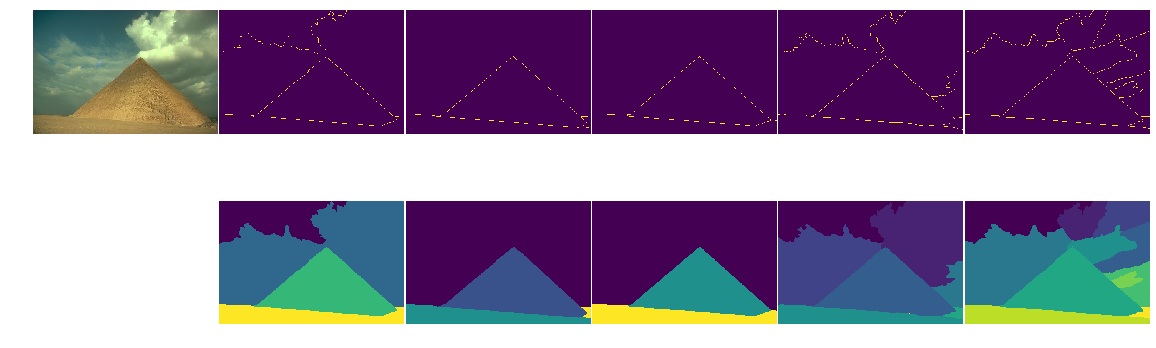

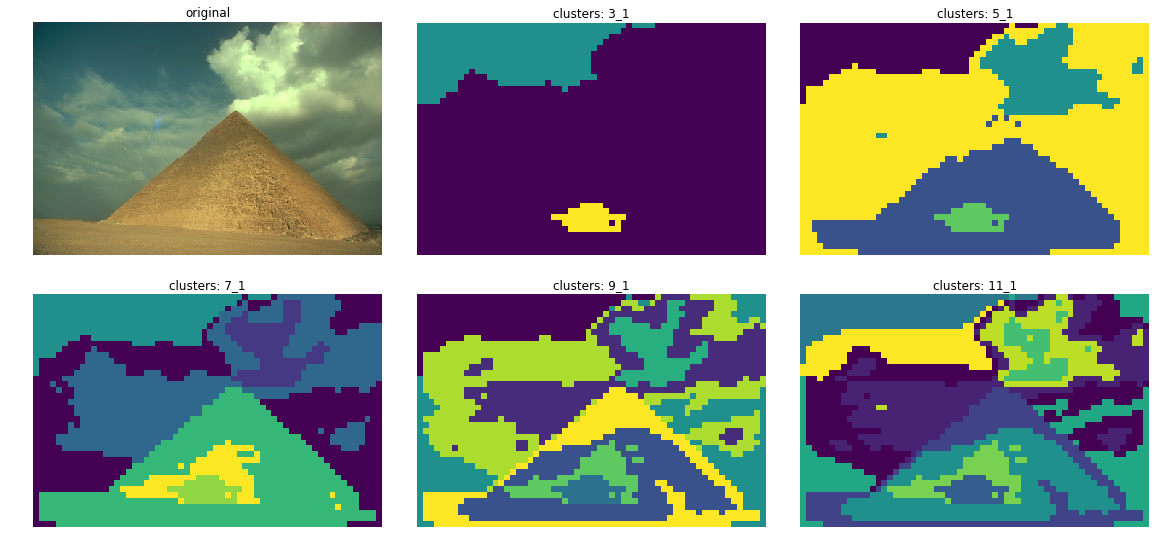

In [165]:
image_report("train", os.path.join(dirc_normalized_nn, "run_1"), pyramid_image, ['3_1', '5_1', '7_1', '9_1', '11_1'])

The previous plots shows a comparison between the groundTruth segmentations and the ones obtained by the normalized_nn method with gamma = 1.

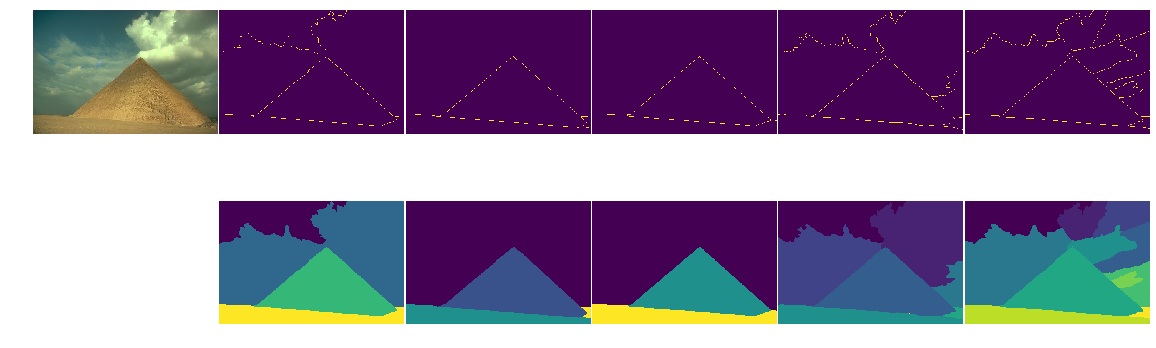

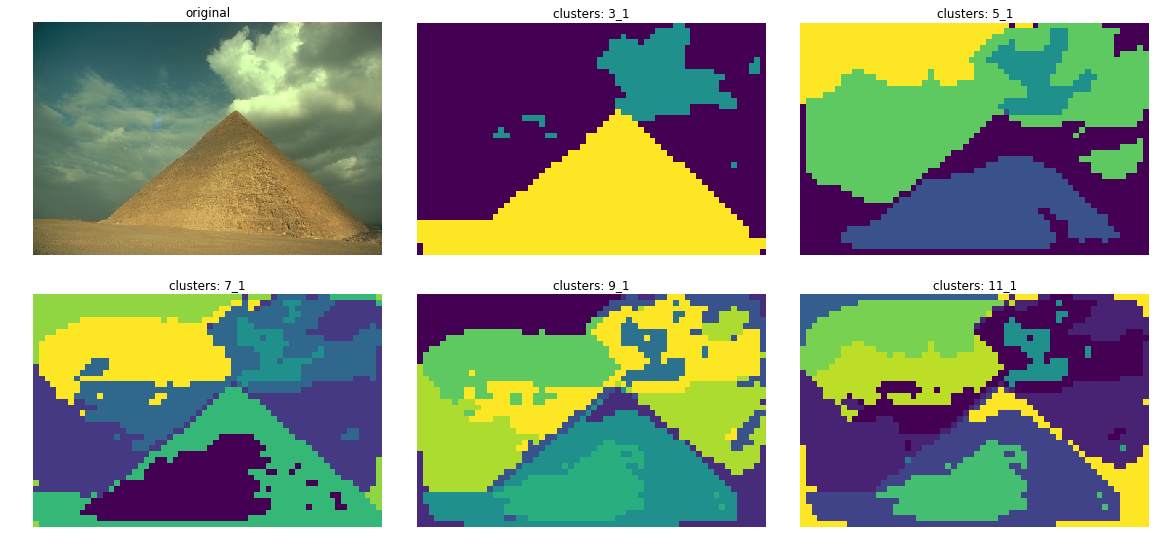

In [166]:
image_report("train", os.path.join(dirc_normalized_rbf, "run_1"), pyramid_image, ['3_1', '5_1', '7_1', '9_1', '11_1'])

The previous plots shows a comparison between the groundTruth segmentations and the ones obtained by the normalized_rbf method with gamma = 10.

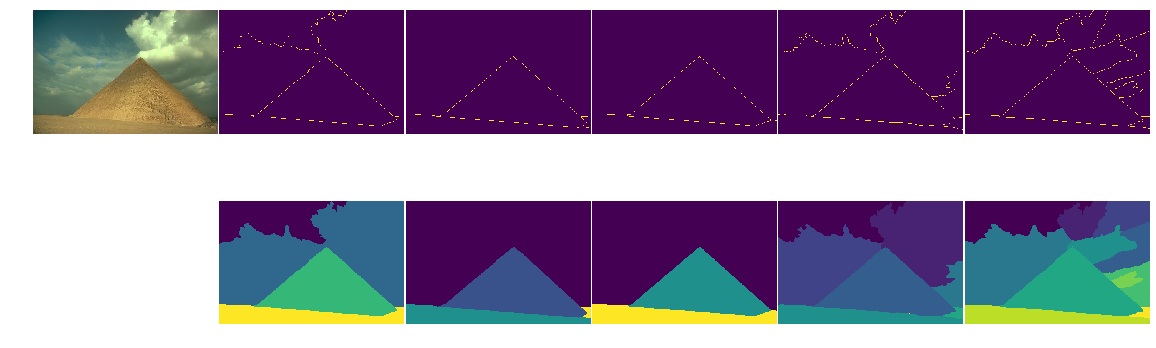

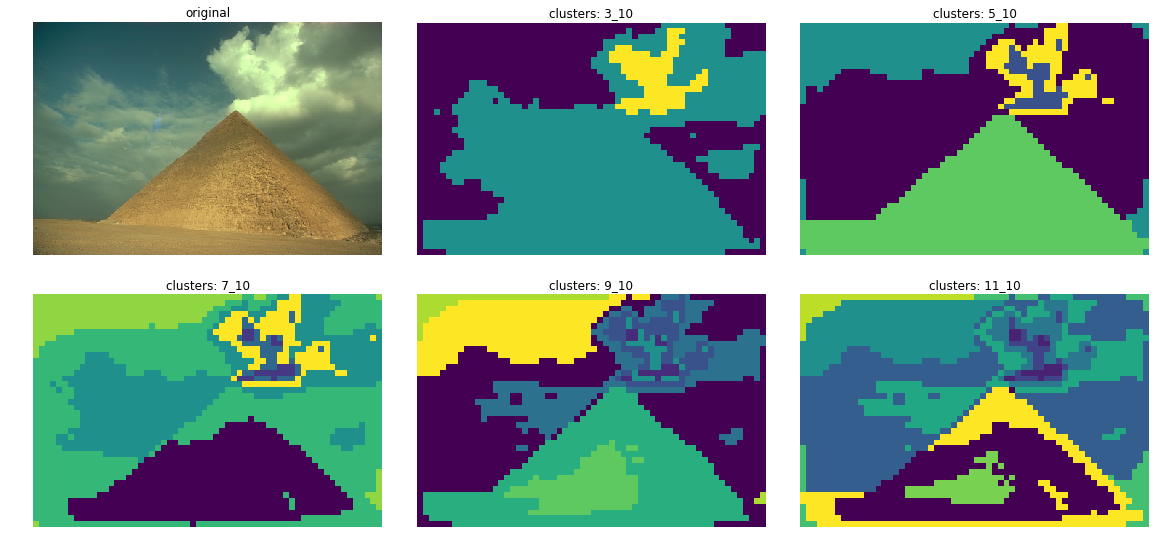

In [167]:
image_report("train", os.path.join(dirc_normalized_rbf, "run_1"), pyramid_image, ['3_10', '5_10', '7_10', '9_10', '11_10'])

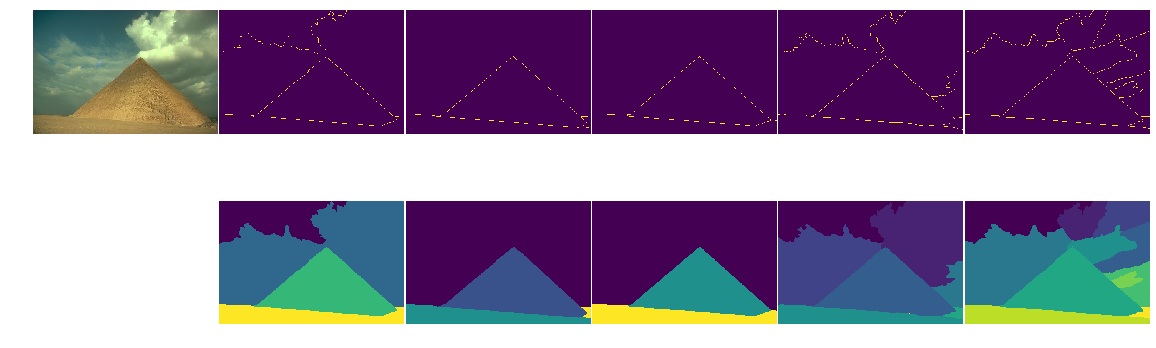

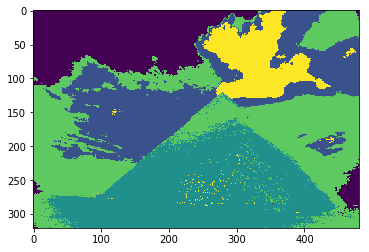

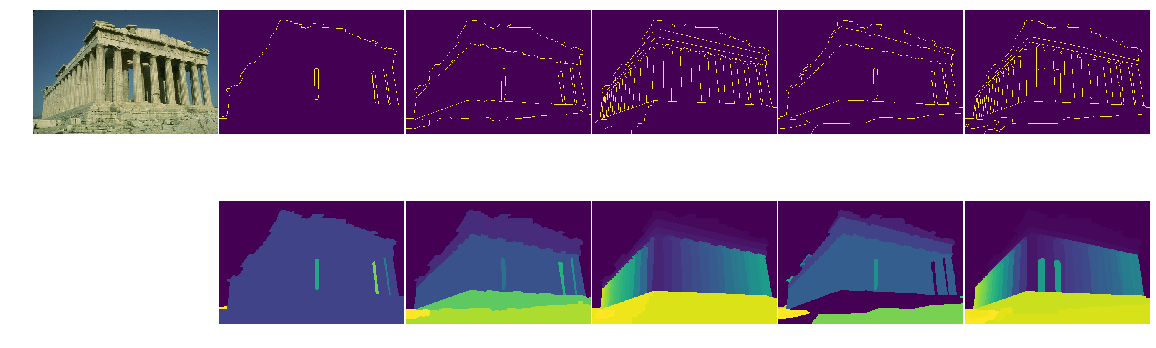

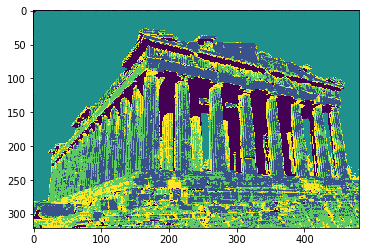

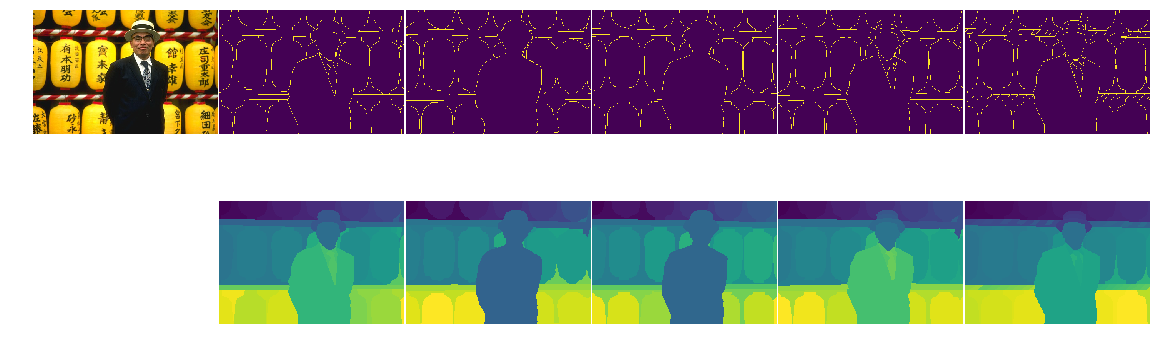

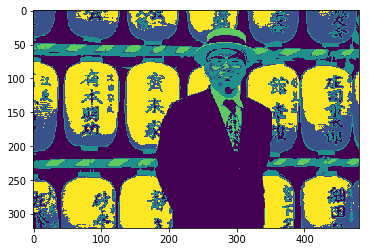

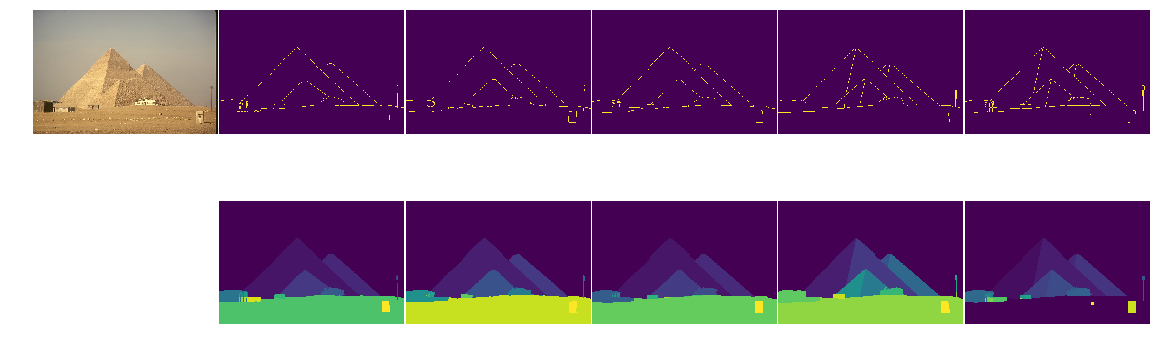

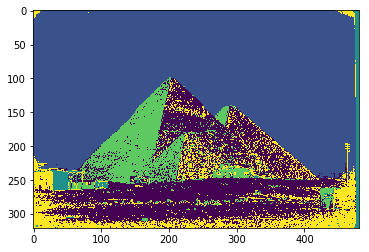

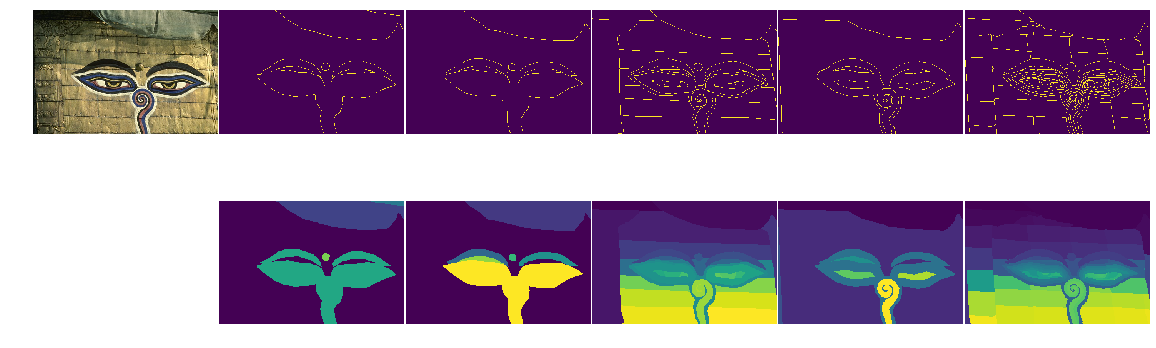

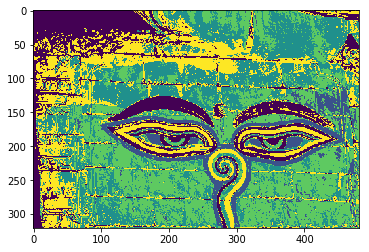

In [168]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    show_image_groundTrue(os.path.join("train", image))
    img = np.load(os.path.join(os.path.join(data_dirc, "kmeans"), "run_1", "5", image + ".npy"))
    plt.imshow(img)
    plt.show()
    

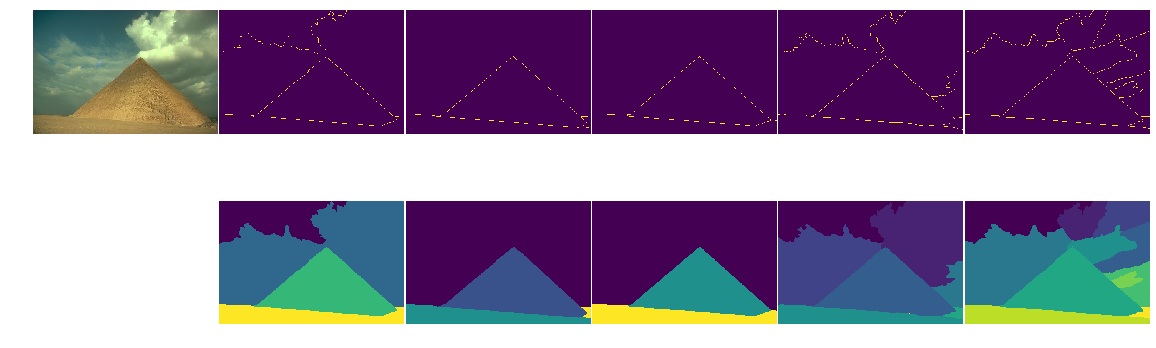

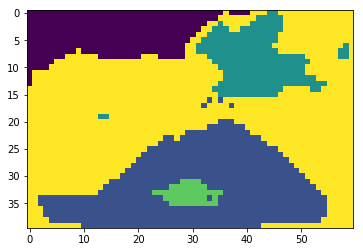

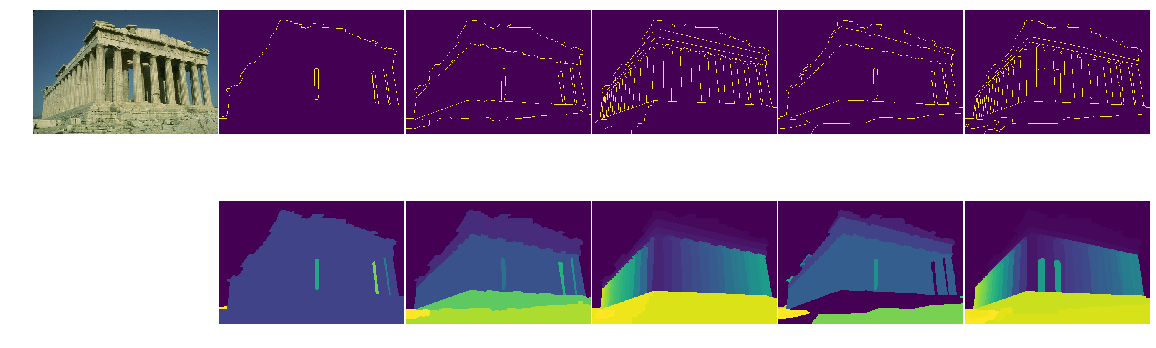

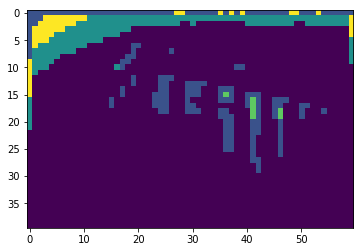

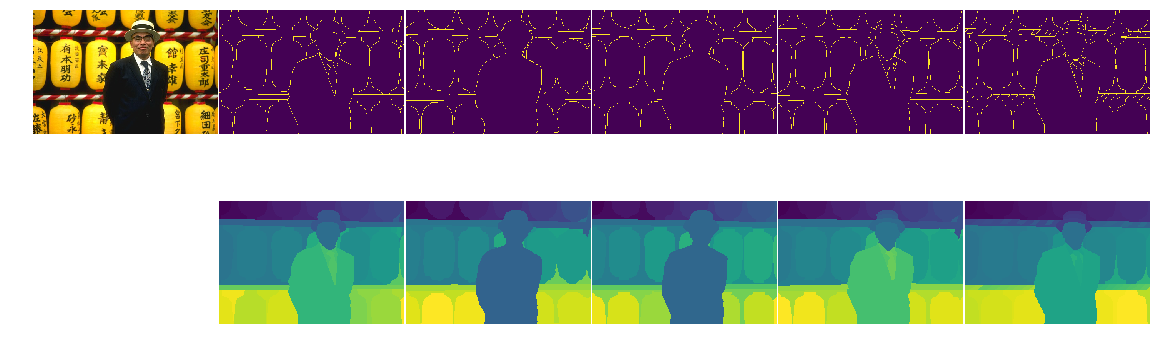

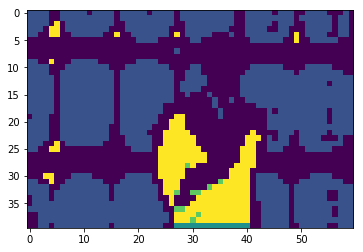

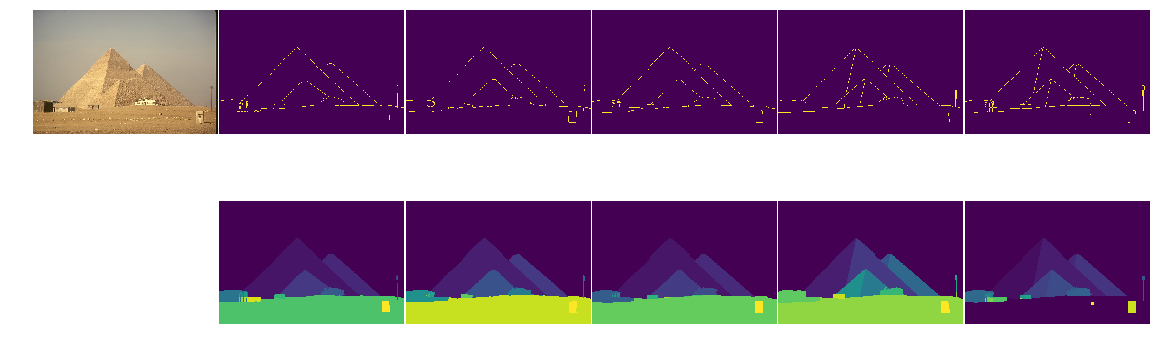

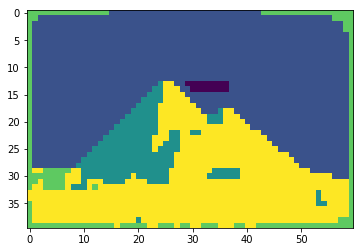

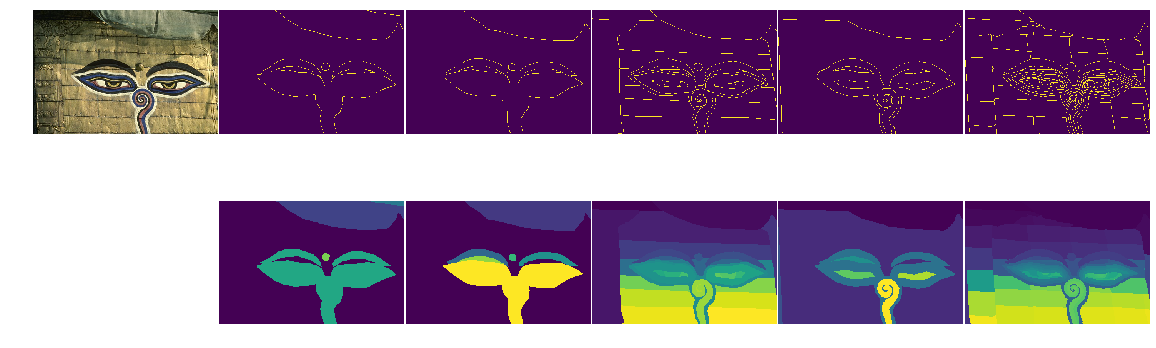

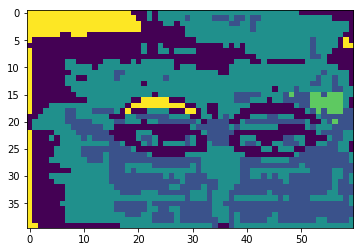

In [172]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    show_image_groundTrue(os.path.join("train", image))
    img = np.load(os.path.join(dirc_normalized_nn, "run_1", "5_1", image + ".npy"))
    plt.imshow(img)
    plt.show()
    

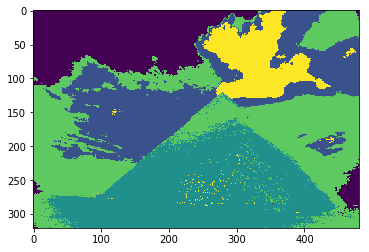

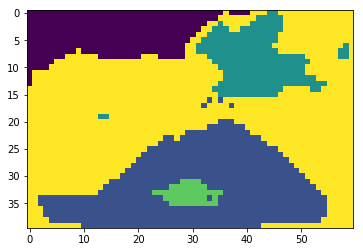

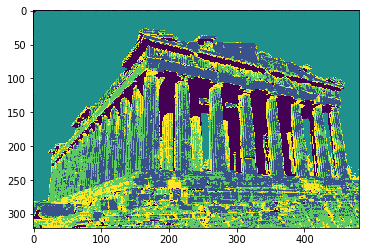

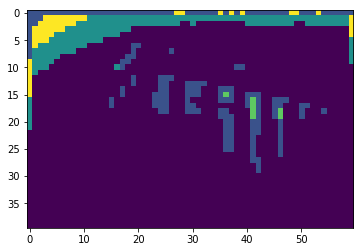

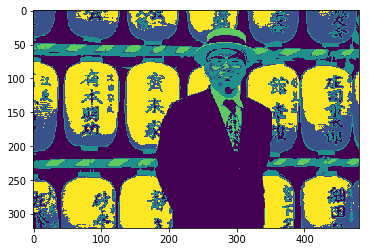

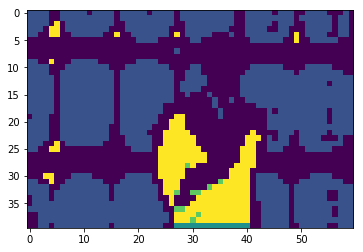

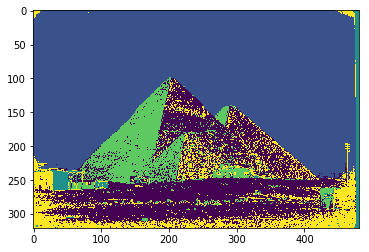

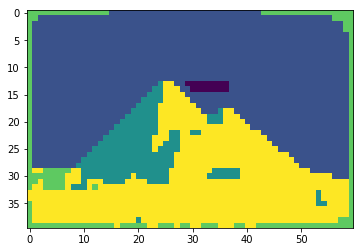

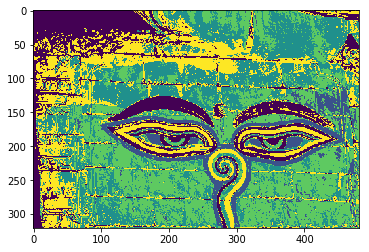

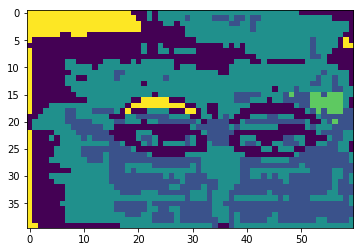

In [169]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    img1 = np.load(os.path.join(os.path.join(data_dirc, "kmeans"), "run_1", "5", image + ".npy"))
    img2 = np.load(os.path.join(dirc_normalized_nn, "run_1", "5_1", image + ".npy"))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()
    print('\n\n\n\n\n\n')

The Last 3 cells shows a comparison between the kmeans method and the normalized_nn method. We came to a conclusion that kmeans seems to be better because normalized_nn needs to reshape the image because it needs a high computing power.